In [1]:
%matplotlib inline
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from SAMPEX_functions import read_counts as read
from SAMPEX_functions import mb_finder, mb_magnitude, iso_calculator, OrbAtt_augment
import pandas as pd
import os
import pathlib
import string

In [2]:
# defining file
year = '1993'
start_day = '255'
#month = 3     # Jan=1, ..., Dec=12

In [3]:
# set end_day
if int(start_day[1]) < 9 or int(start_day[2]) < 4:
    if start_day[0] != '0':
        end_day = str(int(start_day) + 6)
    elif start_day[0] == '0' and start_day[1] != '0':
        end_day = '0' + str(int(start_day) + 6)
    elif start_day[0] == '0' and start_Day[1] == '0':
        end_day = '00' + str(int(start_day) + 6)
elif int(start_day[1]) >= 9 or int(start_day[2]) >= 4:
    end_day = str(int(start_day) + 6)

In [4]:
# reading in electron counts files:
file = ['']*7

for i in np.arange(len(file)):
    if len(str(int(start_day) + i)) == 1:
        file[i] = 'hhrr' + year + '00' + str(int(start_day)+i) + '.txt'
    elif len(str(int(start_day) + i)) == 2:
        file[i] = 'hhrr' + year + '0' + str(int(start_day)+i) + '.txt'
    elif len(str(int(start_day) + i)) == 3:
        file[i] = 'hhrr' + year + str(int(start_day)+i) + '.txt'

t_1, r1_1, r2_1, r3_1, r4_1 = read(file[0]); t_2, r1_2, r2_2, r3_2, r4_2 = read(file[1]); t_3, r1_3, r2_3, r3_3, r4_3 = read(file[2]);
t_4, r1_4, r2_4, r3_4, r4_4 = read(file[3]); t_5, r1_5, r2_5, r3_5, r4_5 = read(file[4]); t_6, r1_6, r2_6, r3_6, r4_6 = read(file[5]);
t_7, r1_7, r2_7, r3_7, r4_7 = read(file[6])

r1 = np.array(list(r1_1) + list(r1_2) + list(r1_3) + list(r1_4) + list(r1_5) + list(r1_6) + list(r1_7))
r2 = np.array(list(r2_1) + list(r2_2) + list(r2_3) + list(r2_4) + list(r2_5) + list(r2_6) + list(r2_7))
r3 = np.array(list(r3_1) + list(r3_2) + list(r3_3) + list(r3_4) + list(r3_5) + list(r3_6) + list(r3_7))
r4 = np.array(list(r4_1) + list(r4_2) + list(r4_3) + list(r4_4) + list(r4_5) + list(r4_6) + list(r4_7))

t_list = [t_1, t_2, t_3, t_4, t_5, t_6, t_7];
r1_list = [r1_1, r1_2, r1_3, r1_4, r1_5, r1_6, r1_7];
r4_list = [r4_1, r4_2, r4_3, r4_4, r4_5, r4_6, r4_7];

t = []

for i in np.arange(len(t_list)):
    t_list[i] += 86400*i
    t += list(t_list[i])
    
t = np.array(t)

In [5]:
# find microburst times and N_100, SSD1, SSD4 counts using algorithm
t_microburst, N_100_microburst, r1_microburst, r4_microburst, mb_index, MB_mask, N_100, A_500 = mb_finder(t, r1, r2, r3, r4)

In [6]:
BG_mask = ~MB_mask

# calculation of the isotropy indices of electron counts
iso_indices_MB = iso_calculator(r1[MB_mask], r4[MB_mask])
iso_indices_BG = iso_calculator(r1[BG_mask], r4[BG_mask])

In [7]:
# reading in orbit/attitude data file
directory = 'D:\SAMPEX_Data\\'
OA_file = 'OrbAtt_' + year + start_day + '-' + year + end_day + '.txt'
OrbAtt_data = pd.read_csv(directory + OA_file, names = ['sec_of_day', 'GEO_Radius', 'GEO_Long', 'GEO_Lat', 'Altitude', 'L_Shell', 'MLT', 
                                         'SAA_Flag', 'Pitch', 'zenith', 'azimuth', 'Att_Flag'], sep = '\s+', header = 70)

t_OrbAtt, LS_OrbAtt, MLT_OrbAtt, P_OrbAtt, Lat_OrbAtt, Long_OrbAtt, R_OrbAtt = OrbAtt_augment(t, OrbAtt_data)

t_OrbAtt_mb = t_OrbAtt[mb_index]; LS_OrbAtt_mb = LS_OrbAtt[mb_index]; MLT_OrbAtt_mb = MLT_OrbAtt[mb_index];
P_OrbAtt_mb = P_OrbAtt[mb_index]; Lat_OrbAtt_mb = Lat_OrbAtt[mb_index]; Long_OrbAtt_mb = Long_OrbAtt[mb_index];
R_OrbAtt_mb = R_OrbAtt[mb_index]

In [8]:
# calculation of B_3 bin percentiles
y_microburst, B_3_microburst, B_3 = mb_magnitude(N_100, N_100_microburst, A_500)

y = N_100 - B_3
y_background = y[BG_mask]

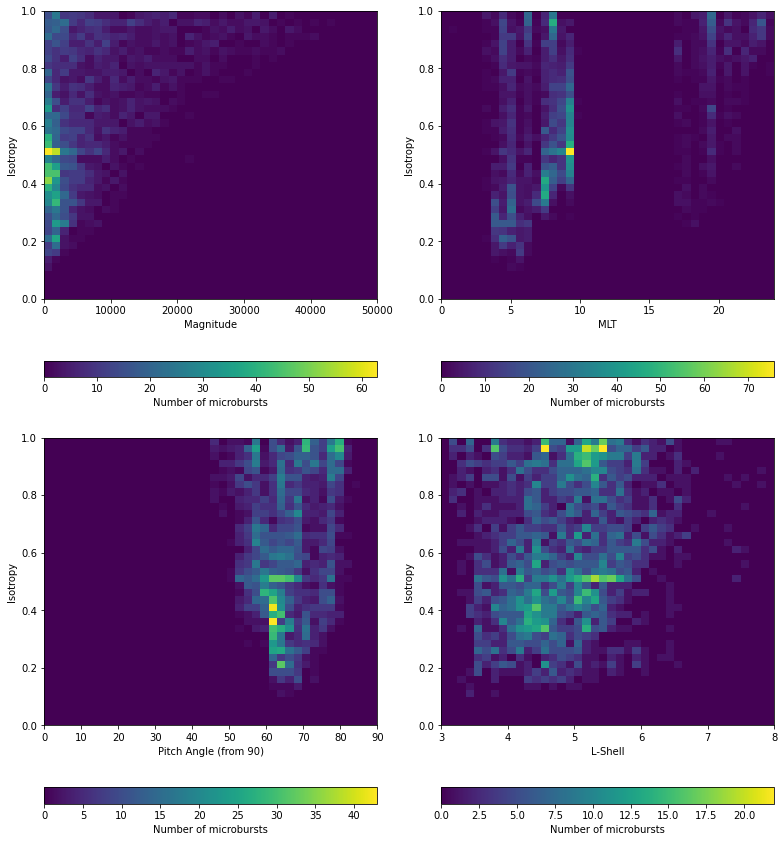

In [9]:
###### MICROBURST ISO vs PARAMETERS #######
max_iso = 1.0
bin_num = 40

iso_bins = np.linspace(0, max_iso, num=bin_num+1)

mag_bins = np.linspace(0, 50000, num=bin_num+1)
MLT_bins = np.linspace(0, 24, num=bin_num+1)
PA_bins = np.linspace(0, 90, num=bin_num+1)
L_bins = np.linspace(3, 8, num=bin_num+1)

# Create histograms
H_IvMag, _, _ = np.histogram2d(y_microburst, iso_indices_MB, bins=[mag_bins, iso_bins])
H_IvMLT, _, _ = np.histogram2d(MLT_OrbAtt_mb, iso_indices_MB, bins=[MLT_bins, iso_bins])
H_IvPA, _, _ = np.histogram2d(np.abs(90 - P_OrbAtt_mb), iso_indices_MB, bins=[PA_bins, iso_bins])
H_IvL, _, _ = np.histogram2d(LS_OrbAtt_mb, iso_indices_MB, bins=[L_bins, iso_bins])

# Make the two plots.
_, ax = plt.subplots(2, 2, figsize=(11, 12))

p_IvMag = ax[0,0].pcolormesh(mag_bins, iso_bins, H_IvMag.T, vmin=0)
plt.colorbar(p_IvMag, ax=ax[0,0], orientation='horizontal', label='Number of microbursts')
ax[0,0].set_xlabel('Magnitude')
ax[0,0].set_ylabel('Isotropy')

p_IvMLT = ax[0,1].pcolormesh(MLT_bins, iso_bins, H_IvMLT.T, vmin=0)
plt.colorbar(p_IvMLT, ax=ax[0,1], orientation='horizontal', label='Number of microbursts')
ax[0,1].set_xlabel('MLT')
ax[0,1].set_ylabel('Isotropy')

p_IvPA = ax[1,0].pcolormesh(PA_bins, iso_bins, H_IvPA.T, vmin=0)
plt.colorbar(p_IvPA, ax=ax[1,0], orientation='horizontal', label='Number of microbursts')
ax[1,0].set_xlabel('Pitch Angle (from 90)')
ax[1,0].set_ylabel('Isotropy')

p_IvL = ax[1,1].pcolormesh(L_bins, iso_bins, H_IvL.T, vmin=0)
plt.colorbar(p_IvL, ax=ax[1,1], orientation='horizontal', label='Number of microbursts')
ax[1,1].set_xlabel('L-Shell')
ax[1,1].set_ylabel('Isotropy')

plt.tight_layout()
plt.show()

In [10]:
print(len(t_OrbAtt_mb))

3583


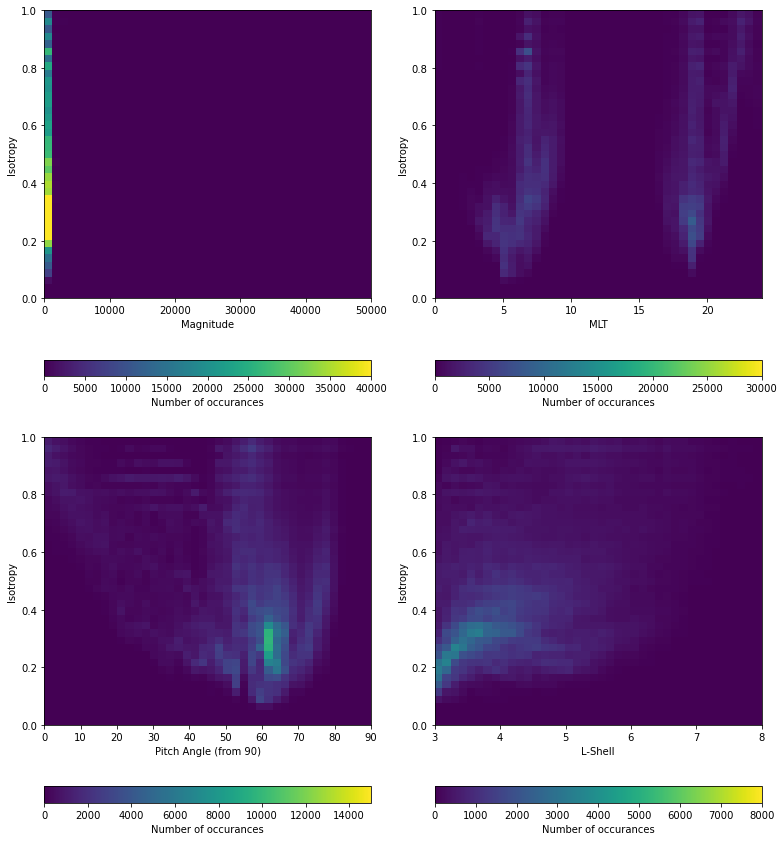

In [11]:
###### BACKGROUND ISO vs PARAMETERS #######
max_iso = 1.0
bin_num = 40

iso_bins = np.linspace(0, max_iso, num=bin_num)

mag_bins = np.linspace(0, 50000, num=bin_num+1)
MLT_bins = np.linspace(0, 24, num=bin_num+1)
PA_bins = np.linspace(0, 90, num=bin_num+1)
L_bins = np.linspace(3, 8, num=bin_num+1)

# Create histograms
H_IvMag, _, _ = np.histogram2d(y_background, iso_indices_BG, bins=[mag_bins, iso_bins])
H_IvMLT, _, _ = np.histogram2d(MLT_OrbAtt[BG_mask], iso_indices_BG, bins=[MLT_bins, iso_bins])
H_IvPA, _, _ = np.histogram2d(np.abs(90 - P_OrbAtt[BG_mask]), iso_indices_BG, bins=[PA_bins, iso_bins])
H_IvL, _, _ = np.histogram2d(LS_OrbAtt[BG_mask], iso_indices_BG, bins=[L_bins, iso_bins])

# Make the two plots.
_, ax = plt.subplots(2, 2, figsize=(11, 12))

p_IvMag = ax[0,0].pcolormesh(mag_bins, iso_bins, H_IvMag.T, vmin=0, vmax=40000)
plt.colorbar(p_IvMag, ax=ax[0,0], orientation='horizontal', label='Number of occurances')
ax[0,0].set_xlabel('Magnitude')
ax[0,0].set_ylabel('Isotropy')

p_IvMLT = ax[0,1].pcolormesh(MLT_bins, iso_bins, H_IvMLT.T, vmin=0, vmax=30000)
plt.colorbar(p_IvMLT, ax=ax[0,1], orientation='horizontal', label='Number of occurances')
ax[0,1].set_xlabel('MLT')
ax[0,1].set_ylabel('Isotropy')

p_IvPA = ax[1,0].pcolormesh(PA_bins, iso_bins, H_IvPA.T, vmin=0, vmax=15000)
plt.colorbar(p_IvPA, ax=ax[1,0], orientation='horizontal', label='Number of occurances')
ax[1,0].set_xlabel('Pitch Angle (from 90)')
ax[1,0].set_ylabel('Isotropy')

p_IvL = ax[1,1].pcolormesh(L_bins, iso_bins, H_IvL.T, vmin=0, vmax=8000)
plt.colorbar(p_IvL, ax=ax[1,1], orientation='horizontal', label='Number of occurances')
ax[1,1].set_xlabel('L-Shell')
ax[1,1].set_ylabel('Isotropy')

plt.tight_layout()
plt.show()

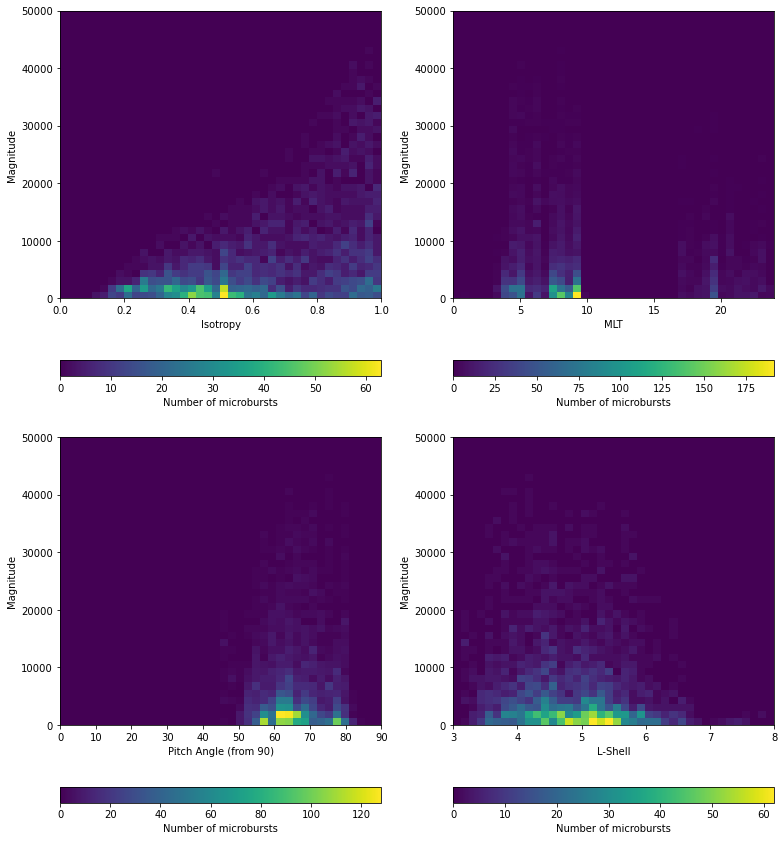

In [12]:
###### MICROBURST MAGNITUDE vs PARAMETERS #######
max_iso = 1.0
bin_num = 40

mag_bins = np.linspace(0, 50000, num=bin_num+1)

iso_bins = np.linspace(0, max_iso, num=bin_num+1)
MLT_bins = np.linspace(0, 24, num=bin_num+1)
PA_bins = np.linspace(0, 90, num=bin_num+1)
L_bins = np.linspace(3, 8, num=bin_num+1)

# Create histograms
H_MagvI, _, _ = np.histogram2d(iso_indices_MB, y_microburst, bins=[iso_bins, mag_bins])
H_MagvMLT, _, _ = np.histogram2d(MLT_OrbAtt_mb, y_microburst, bins=[MLT_bins, mag_bins])
H_MagvPA, _, _ = np.histogram2d(np.abs(90 - P_OrbAtt_mb), y_microburst, bins=[PA_bins, mag_bins])
H_MagvL, _, _ = np.histogram2d(LS_OrbAtt_mb, y_microburst, bins=[L_bins, mag_bins])

# Make the two plots.
_, ax = plt.subplots(2, 2, figsize=(11, 12))

p_MagvI = ax[0,0].pcolormesh(iso_bins, mag_bins, H_MagvI.T, vmin=0)
plt.colorbar(p_MagvI, ax=ax[0,0], orientation='horizontal', label='Number of microbursts')
ax[0,0].set_xlabel('Isotropy')
ax[0,0].set_ylabel('Magnitude')

p_MagvMLT = ax[0,1].pcolormesh(MLT_bins, mag_bins, H_MagvMLT.T, vmin=0)
plt.colorbar(p_MagvMLT, ax=ax[0,1], orientation='horizontal', label='Number of microbursts')
ax[0,1].set_xlabel('MLT')
ax[0,1].set_ylabel('Magnitude')

p_MagvPA = ax[1,0].pcolormesh(PA_bins, mag_bins, H_MagvPA.T, vmin=0)
plt.colorbar(p_MagvPA, ax=ax[1,0], orientation='horizontal', label='Number of microbursts')
ax[1,0].set_xlabel('Pitch Angle (from 90)')
ax[1,0].set_ylabel('Magnitude')

p_MagvL = ax[1,1].pcolormesh(L_bins, mag_bins, H_MagvL.T, vmin=0)
plt.colorbar(p_MagvL, ax=ax[1,1], orientation='horizontal', label='Number of microbursts')
ax[1,1].set_xlabel('L-Shell')
ax[1,1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

In [13]:
print(MLT_OrbAtt_mb)
print(P_OrbAtt_mb)
print(LS_OrbAtt_mb)

[21.9873  21.9873  21.9873  ... 20.9549  16.8283   5.64998]
[141.715  141.715  141.715  ... 155.467   10.9087 161.77  ]
[5.18007 5.18007 5.18007 ... 6.15698 7.22274 6.04456]
